# Training parameterized quantum circuits

The main task of machine learning is to optimze an arbitrary function called the loss function. This is done by calculating the global minimum of this function with respect to the parameters. To apply this method on quantum data we first encode the data using a feature map similar to chapter 3.

After encoding the data a variational circuit is used to calculate the loss function so we finally can make a measurement in order to produce the output of the model.

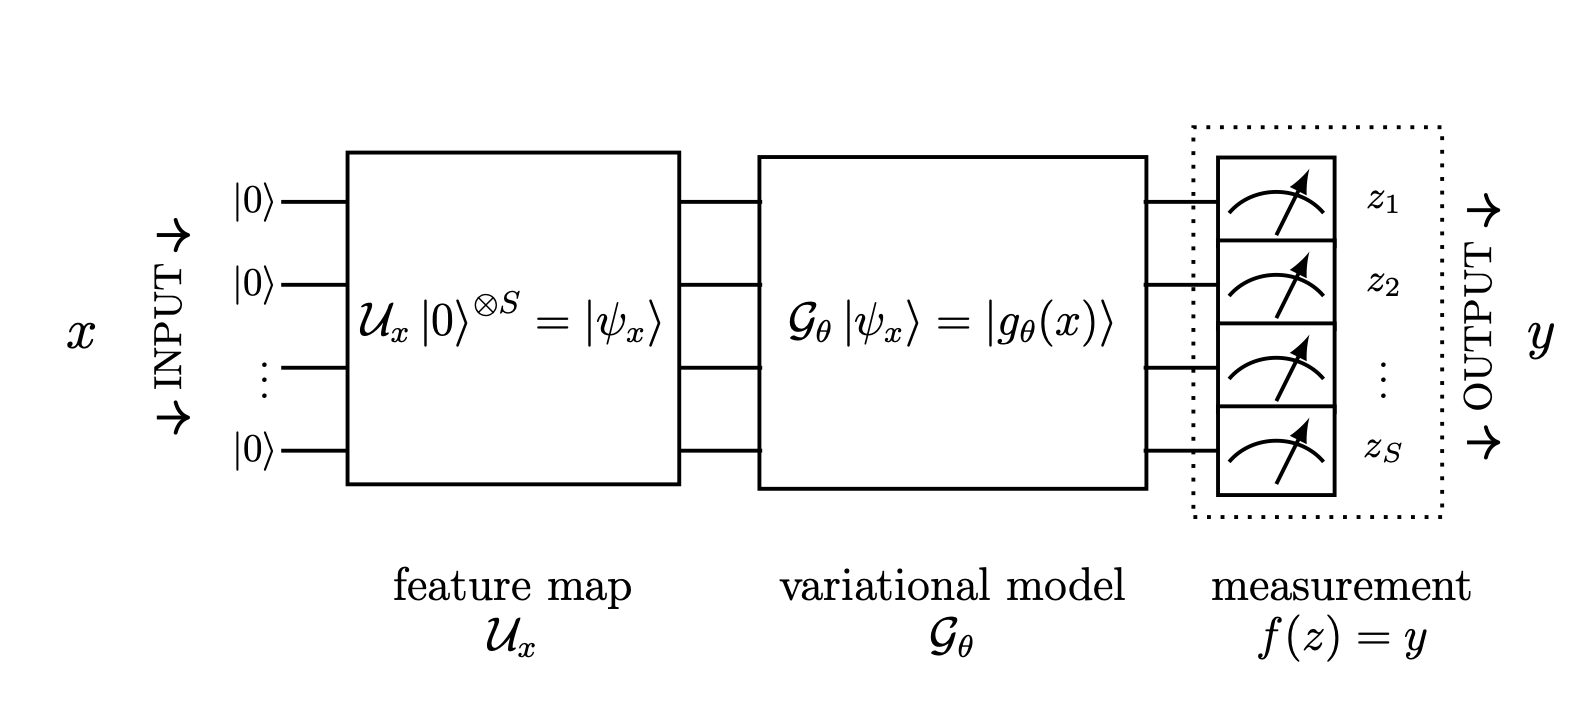

The loss function we are trying to minimize is the expectation value.
\begin{align}
<\psi(\vec{\theta)}|\hat{H}|\psi(\vec{\theta})|>
\end{align}

## Gradients

Now lets try to calculate the global minimum by using the gradients. But first we need to define the parameterized state:


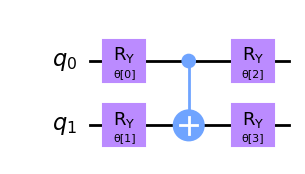

In [2]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw(output="mpl", fold=20)

In [3]:
from qiskit.opflow import Z, I
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit.opflow import StateFn, PauliExpectation
import numpy as np

hamiltonian = Z ^ Z
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)


quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)
point = np.random.random(ansatz.num_parameters)
INDEX = 2

### Finite Gradients

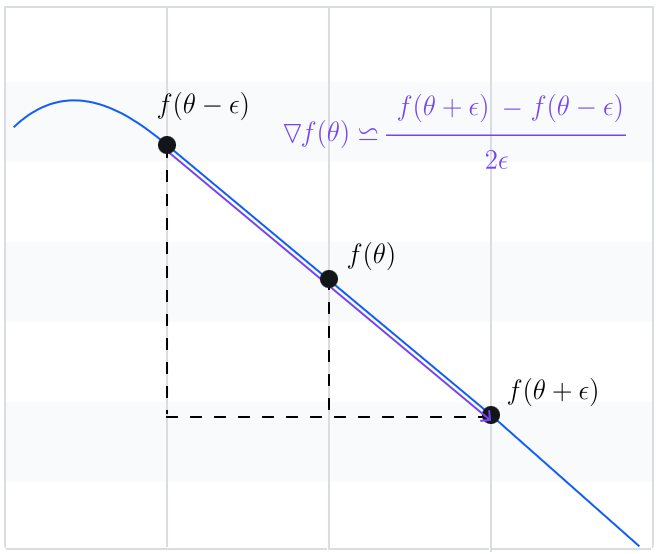

Easiest way to implement the gradient but very volatile to noise.

In [4]:
EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

0.06286621093749979


In [5]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.02197265625

### Analytic Gradients

0.06408691406250006


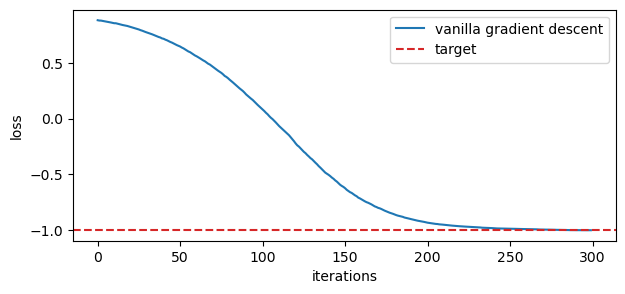

In [6]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

#print(finite_difference)
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
sampler.convert(grad, value_dict).eval().real
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)
result = gd.minimize(
    fun=evaluate_expectation,  # function to minimize
    x0=initial_point,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### Natural Quantum Gradients

The idea of natural gradients is to change the way we determine the updated parameters, by considering the sensitivity of the model. In vanilla gradients, we used the Euclidean distance between them but we saw that this doesn't take the loss landscape into account. With natural gradients, we instead use a distance that depends on our model.

The quantum natural gradient additionally makes use of the quantum fisher information, which allows us to transform the steepest descent in the Euclidean parameter space to the steepest descent in the model space. 

\begin{align}
f_{i,j}(\vec{\theta}) = Re\left\{\left\langle \frac{d\psi(\theta)}{d\theta_i}|\frac{d\psi(\theta)}{d\theta_j} \right\rangle - \left\langle \frac{d\psi(\theta)}{d\theta_i}|\psi \right\rangle \left\langle \psi|\frac{d\psi}{d\theta_j}\right\rangle\right\}
\end{align}

\begin{align}
\vec{\theta_{n+1}} = \vec{\theta_{n}} - \eta · F^{-1}(\vec{\theta})\nabla{f(\vec{\theta_n})}
\end{align}

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587288 -0.86457064 -0.98086125 -0.3382019 ]


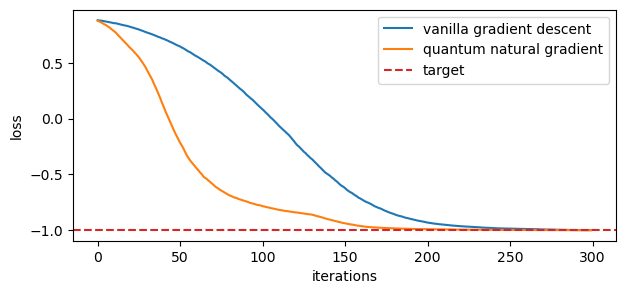

In [12]:
from qiskit.opflow import NaturalGradient
natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(
                                                    natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(natural_gradient, params=value_dict).eval()
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))
qng_log = OptimizerLog()
qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_log.update)

result = qng.minimize(evaluate_expectation,
                      initial_point,
                      evaluate_natural_gradient)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### Simultaneous Perturbation Stochastic Approximation



Approximation (SPSA) is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well.

\begin{align}
\nabla{f(\vec{\theta})} = \begin{pmatrix} \frac{df}{d\theta_1} \\ \vdots \\ \frac{df}{d\theta_n} \end{pmatrix} \approx \frac{1}{2\epsilon} \begin{pmatrix} f(\vec{\theta}+\epsilon \vec{e_1})- f(\vec{\theta}- \epsilon\vec{e_1}) \\ \vdots \\ f(\vec{\theta}+\epsilon \vec{e_n})- f(\vec{\theta}- \epsilon\vec{e_n}) \end{pmatrix} \approx\frac{f(\vec{\theta} + \epsilon\vec{\delta_{rand}}) - f(\vec{\theta}-\epsilon\vec{\delta_{rand}})}{2\epsilon}
\end{align}

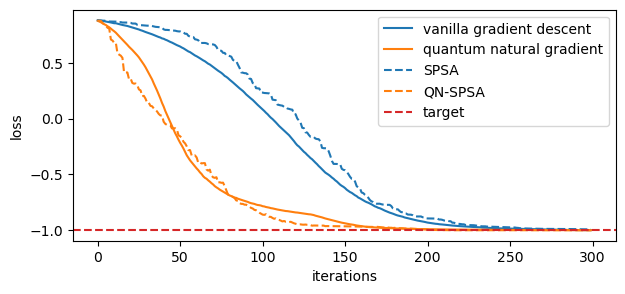

In [15]:
from qiskit.algorithms.optimizers import SPSA
spsa_log = OptimizerLog()
spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_log.update)

result = spsa.minimize(evaluate_expectation, initial_point)

from qiskit.algorithms.optimizers import QNSPSA
qnspsa_log = OptimizerLog()
fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_log.update)

result = qnspsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

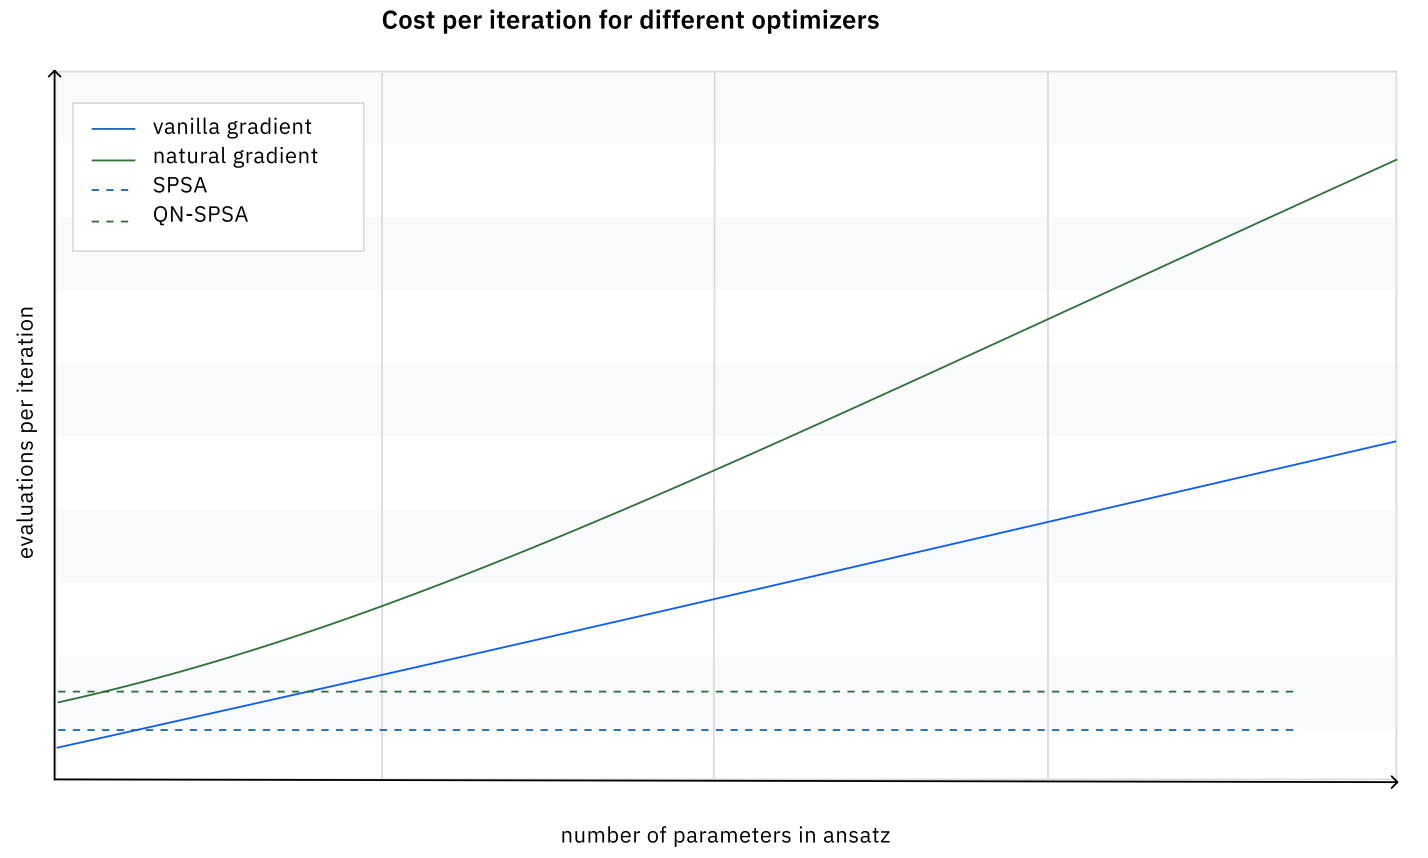

In practice the learning is decreased over time. 

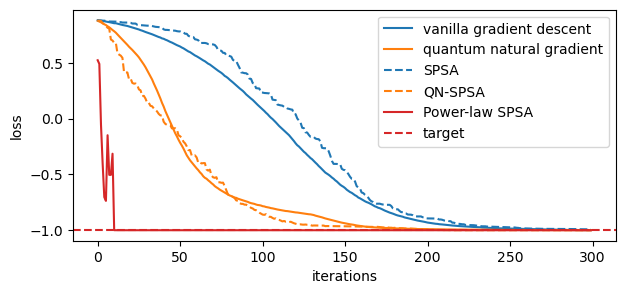

In [16]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_log.update)

result = autospsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', label='Power-law SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

## Barren Plateaous

Barren plateaus discripe a problem that occurs when trying to calculate the global minimum of a function when the gradient function is flat.

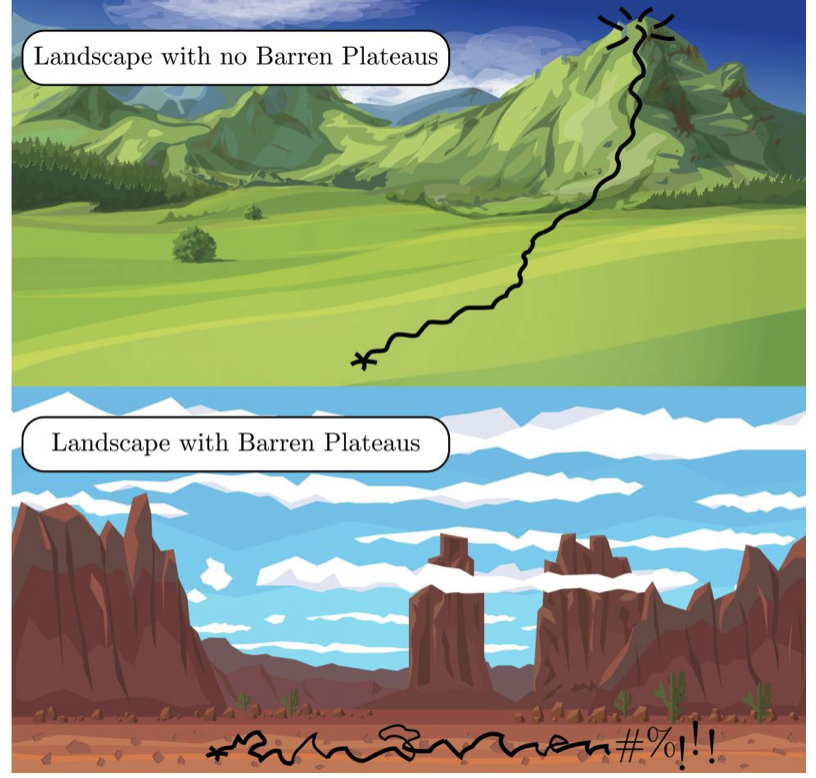

In quantum machine learning this occures for certain types of parameterized circuits, mostly such that have a large amount of parameters. 

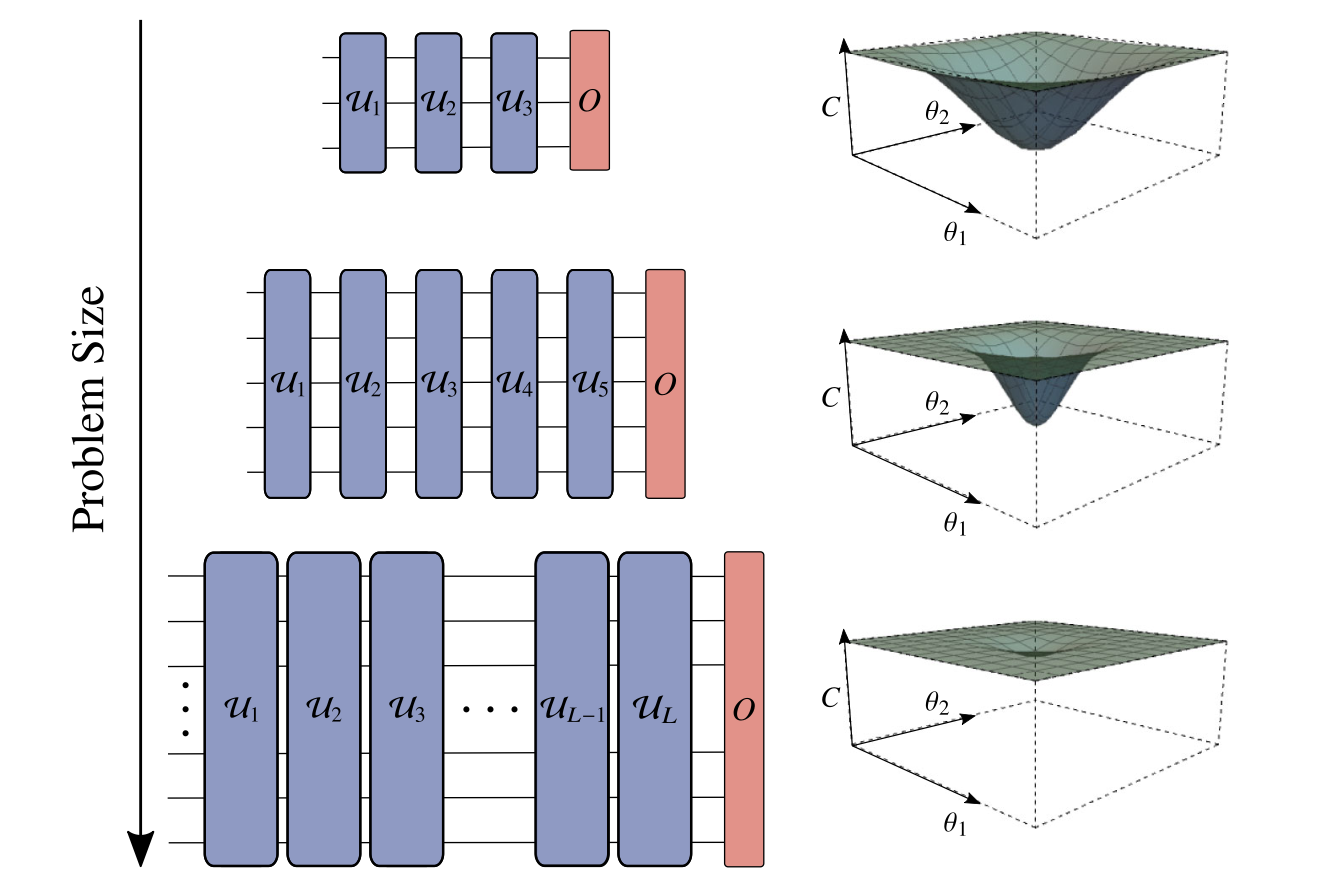

This phenomenon is not new to machine learning as the same issue occures for classical machine learning. Strategies to solve this issue are widely explored and include different weight initialization, modifying activation functions and unsing different optimization functions.

### Fisher Information Matrix and Effective Dimension

Fisher information is a measure of how much information is contained in a random sample about an unknown parameter of a statistical model. It quantifies the amount of uncertainty or variability of the sample in relation to the parameter being estimated.

The Fisher information matrix (FIM) is a matrix of second derivatives of the log-likelihood function with respect to the parameters of interest in a statistical model. It is used to compute the standard errors and covariance matrix of the parameter estimates.

\begin{align}
f_{i,j}(\vec{\theta}) = Re\left\{\left\langle \frac{d\psi(\theta)}{d\theta_i}|\frac{d\psi(\theta)}{d\theta_j} \right\rangle - \left\langle \frac{d\psi(\theta)}{d\theta_i}|\psi \right\rangle \left\langle \psi|\frac{d\psi}{d\theta_j}\right\rangle\right\}
\end{align}

Due to the positive semidefinite nature of the Fisher information matrix and by definition of the Hilbert-Schimdt norm, all matrix entries will approach zero if a model is in a barren plateau, and natural gradient optimisation techniques become unfeasible. We can conclude that a model suffering from a barren plateau will have a Fisher information spectrum with an increasing concentration of eigenvalues approaching zero as the number of qubits in the model increase.

Um einen Vergleich zwischen klassischen und quantum Models zu machen, betrachten wir drei verschiedene Modelle. Einmal ein klassischen Model, ein einfaches quantum model mit einer einfachen feature Map, die leicht zu simulieren ist und ein komplexes Model, das schwer zu simulieren ist. In den folgenden Graphen wurden dann 100 mal d = 40 parameter $\theta \in [-1, 1]^d$ festgelegt und 100 mal die Fischer-Matrix Eigenwerte ausgerechnet. Die Dimension des Inputs und des Outputs wurden dabei immer konstant auf $s_{in} = 4$ und $s_{out} = 2$ gehalten.

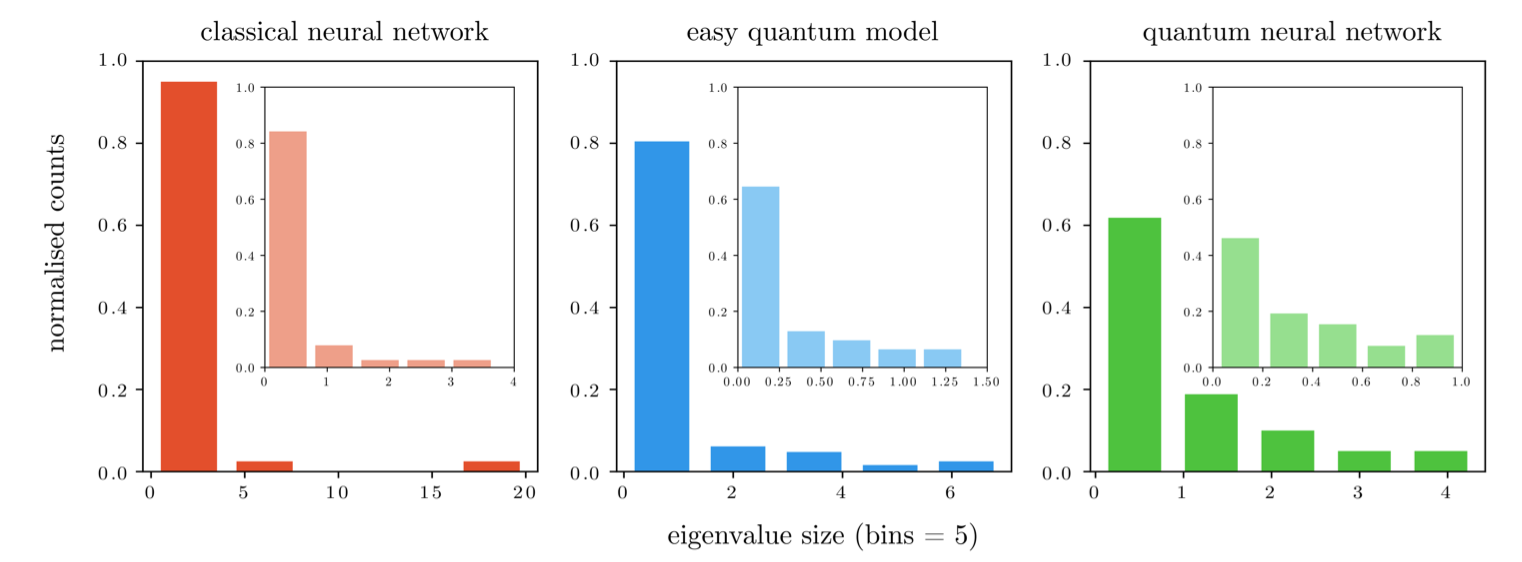

Der Trend führt sich dann für größere ($s_{in}, s_{out}, d$) fort.

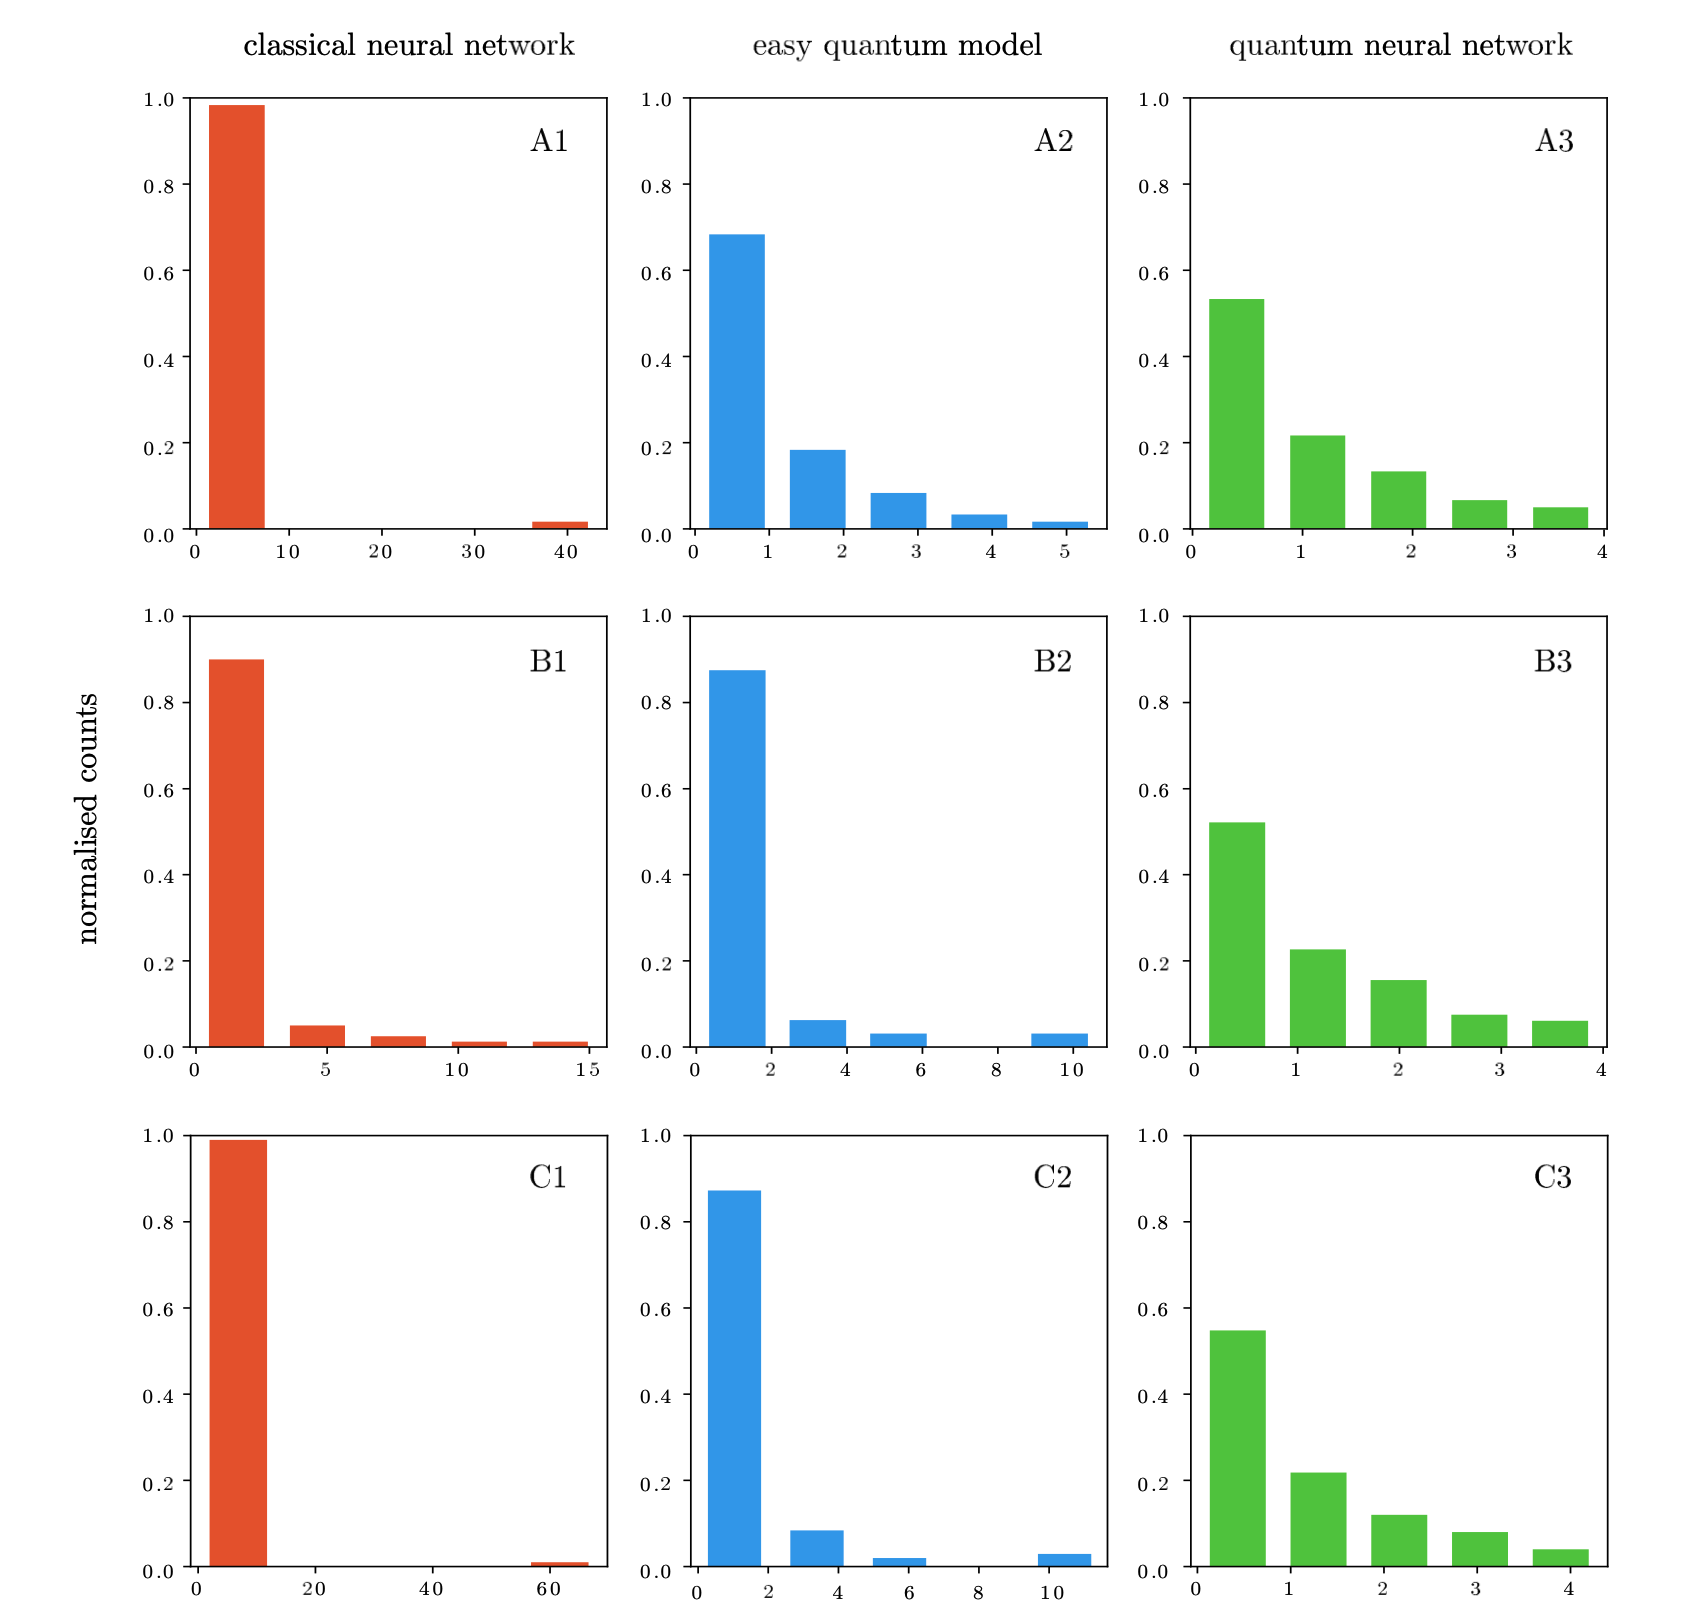

Zeile A: ($s_{in} = 6, s_{out} = 2, d = 60$) $\\$ 
Zeile B: ($s_{in} = 8, s_{out} = 2, d = 80$) $\\$ 
Zeile C: ($s_{in} = 10, s_{out} = 2, d = 100$)

Die effektive Dimension kann uns Informationen über die Komplexität des Machine Learning Models geben. Dabei wird unter anderem auch die Fischer Information genutzt und versucht festzustellen, wie viele Parameter tatsächlich Einfluss auf die Predictions des Models haben. 

\begin{align}
d_{n,\gamma}(M_{\theta}) := \frac{2\log\left(\frac{1}{V_{\theta}}\,\displaystyle\int_{\theta}\sqrt{\vphantom{\big|}\det(id_{d} + \kappa_{n,\gamma}F(\theta))}\,\,d\theta\right)}{\log\kappa_{n,\gamma}}
\end{align}


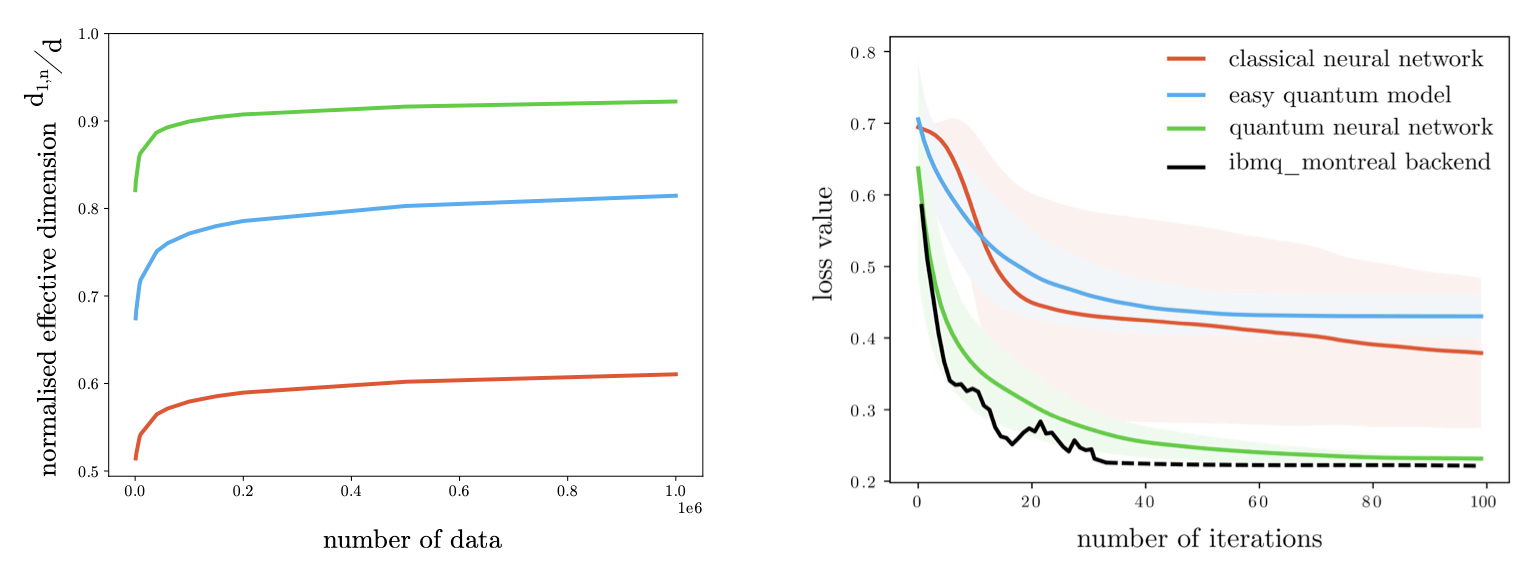

Als Folge der gleichverteilteren Fischer-Matrix Eigenwerte, ist die normalisierte effektive Dimension generell deutlich höher bei dem komplexen Quantum Model und konvergiert sogar gegen die maximale effektive Dimension.
Rechts kann man sehen wie sich die Unterschiede der Fischer Matrizen und effektive Dimension auf die Trainnings-Geschwindigkeit auswirken. Dabei wird klar, dass ein einfaches Quantum Model, das  einfach zu simulieren ist kaum Vorteile bringt, während das komplexe Model sowie eine ähnliche Implementierung auf dem ibmq_montreal mit 27 qubit.

Daraus können wir schließen, dass die Auswahl der richtigen feature Map einen großen Einfluss auf die Performance des Models hat. Die bessere effektive Dimension des komplexen Quantum Models vor allem für größere Datasets gibt einen Hinweis, dass Quantum Machine Learning bei bestimmten Aufgaben einen Vorteil haben könnte, da diese auch nicht gut bzw gar nicht auf einem klassichen Computer simuliert werden können.

### Layer-wise training

Neben der Auswahl einer geeigneten Feature Map, können auch die Variational Circuits dazu beitragen Barren Plataous zu vermeiden. 

Um nachvollziehen zu können, welche Umstände der Variational Circuits zu Barren Plateaus führen, brauchen wir noch eine geeignete Methode das zu messen. Dazu verwenden wir die Varianz des Gradienten bei größer werdenden Models, also der Anzahl der qubits. Die Idee ist, dass wenn die Varianz zu klein ist, haben wir nicht genug Informationen um die Parameter gut zu bestimmen. 

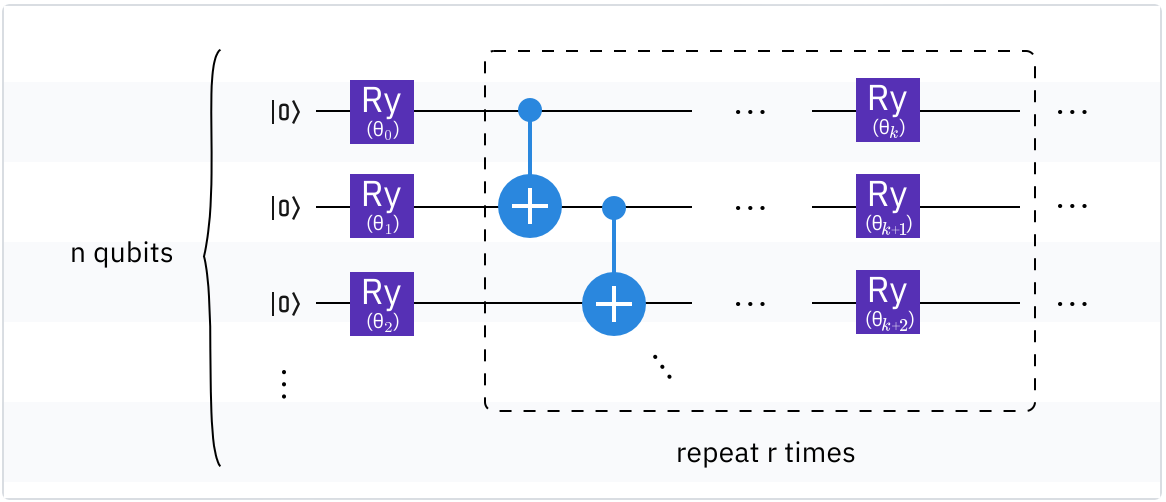

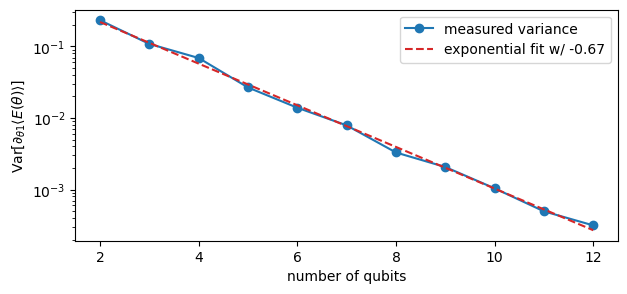

In [18]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.

    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits

    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation,
                              params=ansatz.parameters[index])

    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())

    return grads
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

In [ ]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

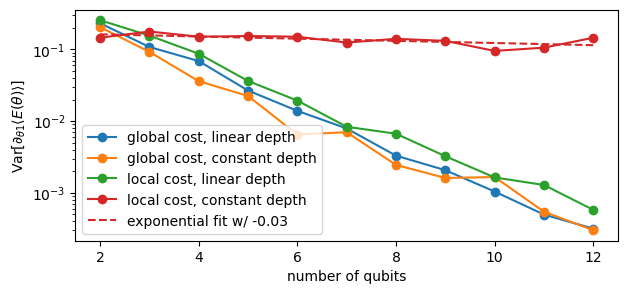

In [21]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]
fixed_depth_local_gradients = [sample_gradients(n, 1,
                                        local=True) for n in num_qubits]
linear_depth_local_gradients = [sample_gradients(n, n,
                                        local=True) for n in num_qubits]
fit = np.polyfit(num_qubits,
                 np.log(np.var(fixed_depth_local_gradients, axis=1)),
                 deg=1)

x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1),
             'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1),
             'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1),
             'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

We see that the variance of the local operator, constant depth circuit gradients don't vanish, that is, we don't get barren plateaus. However, these circuits are usually easy to simulate and hence these models won't provide any advantage over classical models.

This is the inspiration for layer-wise training, where we start with a basic circuit that may not provide any quantum advantage, with one layer of rotations using local operators. We optimize and fix these parameters, then in the next step, we add a second layer of rotations using local operators, and optimize and fix those, and continue for however many layers we want. This potentially avoids barren plateaus as each optimization step is only using constant depth circuits with local operators.

In [22]:
NUM_QUBITS = 6
OPERATOR = Z ^ Z ^ (I ^ (NUM_QUBITS - 4))

def minimize(circuit, optimizer):
    """
    Args:
        circuit (QuantumCircuit): (Partially bound) ansatz circuit to train
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        OptimizerResult: Result of minimization
    """
    initial_point = np.random.random(circuit.num_parameters)

    exp = StateFn(OPERATOR, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)

    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")

    def loss(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(exp, values_dict).eval())

    def gradient(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.minimize(loss, initial_point, gradient)

def layerwise_training(ansatz, max_num_layers, optimizer):
    """
    Args:
        ansatz (QuantumCircuit): Single circuit layer to train & repeat
        max_num_layers (int): Maximum number of layers
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        float: Lowest value acheived
        list[float]: Best parameters found
    """
    optimal_parameters = []
    for reps in range(max_num_layers):
        ansatz.reps = reps

        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.bind_parameters(values_dict)

        result = minimize(partially_bound, optimizer)
        optimal_parameters += list(result.x)
        print('Layer:', reps, ' Best Value:', result.fun)

    return result.fun, optimal_parameters

ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

np.random.seed(12)  # for reproducibility
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Layer: 0  Best Value: 0.6162109375
Layer: 1  Best Value: 0.25537109375000006
Layer: 2  Best Value: -0.12353515625
Layer: 3  Best Value: -0.546875


## 